In [1]:
import time
start_time=time.time()

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import interpolate
import pickle

import strucfunc
from strucfunc import sosflog
import bfunc

In [3]:
name = 'Dor'

In [4]:
pickle_in = open('VFM//' + name + '.pkl',"rb")
data = pickle.load(pickle_in)
sb = data['sb']
vv = data['vv']
ss = data['ss']

In [5]:
## Replace spurious values in the arrays
m = ~np.isfinite(sb*vv*ss) | (sb < 0.0)

sb[m] = 0.0
vv[m] = np.nanmean(vv)
ss[m] = 0.0
sb /= sb.max()

good = (~m) & (sb > 0.001)

In [6]:
sb.shape

(650, 650)

In [7]:
box_size = np.sqrt(650 * 650) * data['pix'] * data['pc']

In [8]:
rslt = strucfunc.strucfunc_numba_parallel(data['vv'], wmap=data['sb'], dlogr=0.05)

C:\Users\ZAINTEL2\Dropbox\Articulos\PhD\PhD-master02\strucfunc.py:83: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
C:\Users\ZAINTEL2\Dropbox\Articulos\PhD\PhD-master02\strucfunc.py:84: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


In [9]:
good = (~m) & (sb > 0.001)
rslt["Unweighted mean velocity"] = np.mean(vv[good])
rslt["Unweighted sigma^2"] = np.var(vv[good])
v0w = rslt["Weighted mean velocity"] = np.average(vv, weights=sb)
rslt["Weighted sigma^2"] = np.average((vv - v0w)**2, weights=sb)

In [10]:
b2 = rslt['Unweighted B(r)']
e_b2 = b2  *.1
s = 10**rslt['log10 r'] * data['pix'] * data['pc']
e_s = s  *.1
sig2 = rslt['Unweighted sigma^2']
sig = sig2**0.5

In [26]:
r0 = np.interp(sig2, b2, s,period = 90)
r0

3.3516931069057883

x = s
y = b2 - sig2
tck=interpolate.splrep(x,y,s=0)
grid=np.linspace(x.min(),x.max(),num=len(x))
ynew=interpolate.splev(grid,tck,der=0)
inter=pd.DataFrame([grid,ynew]).T
SFr=interpolate.sproot(tck)
r0 = SFr[0]

In [12]:
r1 = np.interp(sig, b2, s,period = 360)
r1

0.17749101118305466

In [13]:
r2 = np.interp(2*sig2, b2, s, period = 360)
r2

1.4893367870202796

(252.11363212022405, 3.3516931069057883, 1.0, 0.21816615649929116, 10.0)

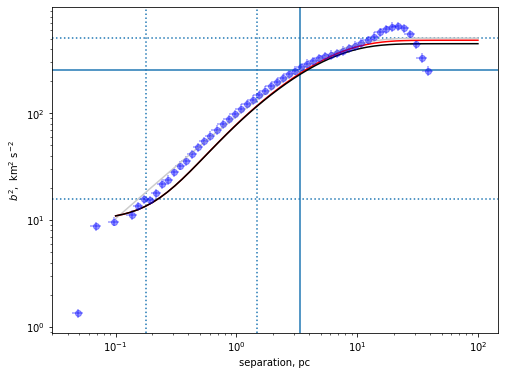

In [27]:
m = 1.0
noise = 10.0
s0 = data['s0']

fig, ax = plt.subplots(figsize=(8, 6))
rgrid = np.logspace(-1, 2.0)
ax.errorbar(s, b2, yerr=e_b2, xerr=e_s, fmt='o', alpha=0.4,color="blue")


ax.axhline(sig2, ls='-')
ax.axvline(r0, ls='-')

ax.axhline(2*sig2, ls=':')
ax.axvline(r2, ls=':')

ax.axhline(sig, ls=':')
ax.axvline(r1, ls=':')

ax.plot(rgrid, bfunc.bfunc00s(rgrid, r0, sig2, m), color="0.8")
ax.plot(rgrid, bfunc.bfunc03s(rgrid, r0, sig2, m, s0, noise), color="red")
ax.plot(rgrid, bfunc.bfunc04s(rgrid, r0, sig2, m, s0, noise, box_size), color="black")


ax.set(xscale='log', yscale='log', 
       xlabel='separation, pc',
       ylabel=r'$b^2,\ \mathrm{km^2\ s^{-2}}$'
      )
None

sig2, r0, m, s0, noise

In [28]:
rslt

{'log10 r': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
        1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
        2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 ,
        2.75, 2.8 , 2.85, 2.9 ]),
 'Sum dv^2': array([4.86617781e+05, 0.00000000e+00, 0.00000000e+00, 6.34022538e+06,
        0.00000000e+00, 0.00000000e+00, 1.75075795e+07, 0.00000000e+00,
        0.00000000e+00, 1.21317258e+07, 1.93616908e+07, 2.24051519e+07,
        3.83796631e+07, 5.78030531e+07, 6.26427410e+07, 9.38788049e+07,
        1.90969879e+08, 1.84226024e+08, 2.93354900e+08, 4.53906666e+08,
        7.78869898e+08, 9.06108502e+08, 1.29783240e+09, 2.08220099e+09,
        2.63391174e+09, 3.85163807e+09, 5.60204275e+09, 7.64035068e+09,
        1.03909367e+10, 1.41879127e+10, 2.05456672e+10, 2.65745483e+1

In [29]:
Dor = { 'VF' : data,
        'SF' : rslt,
        's' : s,
        'b2' : b2,
        'sig2' : sig2,
        'pc' : data['pc'],
        'r0' : r0,
        'r1' : r1,
        'r2' : r2,
        's0' : data['s0'],
        'pix' : data['pix'],
        'box_size': box_size}

In [30]:
f = open('Results\\SF'+ name + '.pkl',"wb")
pickle.dump(Dor,f)
f.close()

In [31]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 921.3182220458984 seconds ---
